# A complete workflow of visual search


### Load images into Document Array

In [2]:
from docarray import DocumentArray, Document
import torchvision

# Convert to tensor, normalize so they're all similar enough
def preproc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_shape((80, 60))  # ensure all images right size (dataset image size _should_ be (80, 60))
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis for the PyTorch model later

indexing_documents = DocumentArray.from_files("./aviation_imgs/left/*.jpg", size=10000)
indexing_documents.apply(preproc)
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50

indexing_documents.embed(model, device="cpu")

                             Documents Summary                              
                                                                            
  Length                 63                                                 
  Homogenous Documents   True                                               
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')  
                                                                            
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  embedding   ('Tensor',)    63               False            
  id          ('str',)       63               False            
  mime_type   ('str',)       1                False            
  tensor      ('str',)       63               False            
  uri         ('ndarray',)   63               False            
                                                               
          Storage Summary          
                                   
  Class     DocumentArrayInMemory  
  Backend   In Memory

### Initialize

In [3]:
# construct left/right document arrays
right_da = indexing_documents
left_da = DocumentArray([indexing_documents[0]]) # change THIS index!

# match document arrays by use of embedding (feature vector similarity)
left_da.match(right_da, limit=9)

# show cosine distance of top 9 from query
for d in left_da:
    for m in d.matches:
        print(f"query_uri: {d.uri}, match_uri: {m.uri}, scores: {m.scores['cosine'].value}")    

query_uri: ./aviation_imgs/left/boeing_747_11.jpg, match_uri: ./aviation_imgs/left/boeing_747_11.jpg, scores: 4.172325134277344e-07
query_uri: ./aviation_imgs/left/boeing_747_11.jpg, match_uri: ./aviation_imgs/left/boeing_737_23.jpg, scores: 0.2674490213394165
query_uri: ./aviation_imgs/left/boeing_747_11.jpg, match_uri: ./aviation_imgs/left/boeing_747_16.jpg, scores: 0.288726806640625
query_uri: ./aviation_imgs/left/boeing_747_11.jpg, match_uri: ./aviation_imgs/left/boeing_747_4.jpg, scores: 0.3054542541503906
query_uri: ./aviation_imgs/left/boeing_747_11.jpg, match_uri: ./aviation_imgs/left/boeing_747_13.jpg, scores: 0.317976713180542
query_uri: ./aviation_imgs/left/boeing_747_11.jpg, match_uri: ./aviation_imgs/left/boeing_777_52.jpg, scores: 0.35614079236984253
query_uri: ./aviation_imgs/left/boeing_747_11.jpg, match_uri: ./aviation_imgs/left/boeing_737_34.jpg, scores: 0.36825424432754517
query_uri: ./aviation_imgs/left/boeing_747_11.jpg, match_uri: ./aviation_imgs/left/boeing_737_2

### Display query image

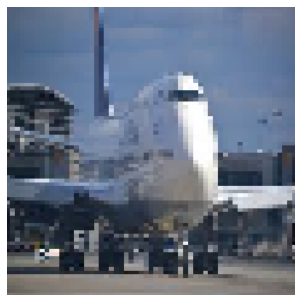

In [4]:
(DocumentArray(left_da[0], copy=True) # dont change this index!
    .apply(lambda d: d.set_image_tensor_channel_axis(0, -1)
                      .set_image_tensor_inv_normalization())
    .plot_image_sprites())

### Display top 9 matches

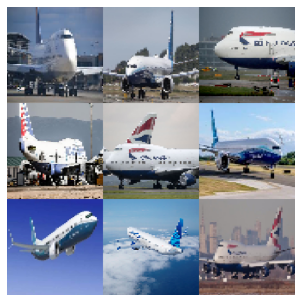

In [5]:
(DocumentArray(left_da[0].matches, copy=True) # dont change this index!
    .apply(lambda d: d.set_image_tensor_channel_axis(0, -1)
                      .set_image_tensor_inv_normalization())
    .plot_image_sprites())

In [6]:
print(left_da[0].uri)

./aviation_imgs/left/boeing_747_11.jpg


In [7]:
groundtruth = DocumentArray(
    Document(uri=d.uri, matches=[Document(uri=d.uri.replace('left', 'right'))]) for d in left_da)

In [8]:
for k in range(1, 6):
    print(f'recall@{k}',
          left_da.evaluate(
            groundtruth,
            hash_fn=lambda d: d.uri,
            metric='recall_at_k',
            k=k,
            max_rel=1))

recall@1 0.0
recall@2 0.0
recall@3 0.0
recall@4 0.0
recall@5 0.0


### [INFO] below metrics are wrong. need to debug.

In [9]:
print(left_da)
for l in left_da:
    print(l)
    print(l.mime_type)
    print(l.matches)

<DocumentArray (length=1) at 140641925577744>
<Document ('id', 'tensor', 'mime_type', 'uri', 'embedding', 'evaluations', 'matches') at 51ca191a951411ec9d06a13bfeffaa0a>
image/jpeg
<DocumentArray (length=9) at 140641671906304>
